# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
# импортируем нужные библиотеки

# pandas
import pandas as pd

# numpy
import numpy as np

# matplotlib
from matplotlib import pyplot

# stats
from scipy import stats as st

### Описание данных

<strong>Таблица users (информация о пользователях):</strong>
<br>user_id — уникальный идентификатор пользователя
<br>first_name — имя пользователя
<br>last_name — фамилия пользователя
<br>age — возраст пользователя (годы)
<br>reg_date — дата подключения тарифа (день, месяц, год)
<br>churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
<br>city — город проживания пользователя
<br>tarif — название тарифного плана

<strong><br>Таблица calls (информация о звонках):</strong>
<br>id — уникальный номер звонка
<br>call_date — дата звонка
<br>duration — длительность звонка в минутах
<br>user_id — идентификатор пользователя, сделавшего звонок

<strong><br>Таблица messages (информация о сообщениях):</strong>
<br>id — уникальный номер сообщения
<br>message_date — дата сообщения
<br>user_id — идентификатор пользователя, отправившего сообщение

<strong><br>Таблица internet (информация об интернет-сессиях):</strong>
<br>id — уникальный номер сессии
<br>mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
<br>session_date — дата интернет-сессии
<br>user_id — идентификатор пользователя

<strong><br>Таблица tariffs (информация о тарифах):</strong>
<br>tariff_name — название тарифа
<br>rub_monthly_fee — ежемесячная абонентская плата в рублях
<br>minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
<br>messages_included — количество сообщений в месяц, включённых в абонентскую плату
<br>mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
<br>rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
<br>rub_per_message — стоимость отправки сообщения сверх тарифного пакета
<br>rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### users

In [2]:
# загрузим users в переменную users
users = pd.read_csv("/datasets/users.csv")

In [3]:
# выведем 5 строк датафрейма
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
# приведем данные колонки reg_date к типу datetime64
users['reg_date'] = pd.to_datetime(
    users['reg_date'], format='%Y.'
)

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [6]:
print('Количество явных дубликатов в датафрейме:', users.duplicated().sum())

Количество явных дубликатов в датафрейме: 0


In [7]:
print('В столбце churn_date пропущено значений:', users['churn_date'].isna().sum())

В столбце churn_date пропущено значений: 462


 Данные столбца churn_date - это дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

Подсчитаем количество пользователей каждого тарифа.

In [8]:
print("Пользователей тарифа смарт:",len(users.query('tariff=="smart"')))

Пользователей тарифа смарт: 351


In [9]:
print("Пользователей тарифа ультра:",len(users.query('tariff=="ultra"')))

Пользователей тарифа ультра: 149


#### calls

In [10]:
# загрузим calls в переменную calls
calls = pd.read_csv("/datasets/calls.csv")

In [11]:
# выведем 5 строк датафрейма
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

In [13]:
# приведем данные столбца duration к типу integer с округлением вверх

calls['duration']=np.ceil(calls.duration).astype(int)

In [14]:
# выведем 5 строк датафрейма
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [15]:
# приведем данные колонки call_date к типу datetime64

calls['call_date'] = pd.to_datetime(
    calls['call_date'], format='%Y.'
)

In [16]:
print('Количество явных дубликатов в датафрейме:', calls.duplicated().sum())

Количество явных дубликатов в датафрейме: 0


#### messages

In [17]:
# загрузим messages в переменную messages
messages = pd.read_csv("/datasets/messages.csv")

In [18]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [20]:
# приведем данные колонки message_date к типу datetime64

messages['message_date'] = pd.to_datetime(
    messages['message_date'], format='%Y.'
)

In [21]:
print('Количество явных дубликатов в датафрейме:', messages.duplicated().sum())

Количество явных дубликатов в датафрейме: 0


#### internet

In [22]:
# загрузим internet в переменную internet
internet = pd.read_csv("/datasets/internet.csv")

In [23]:
# выведем 5 строк датафрейма
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [25]:
# приведем данные колонки session_date к типу datetime64
internet['session_date'] = pd.to_datetime(
    internet['session_date'], format='%Y.'
)

В данных обнаружена колонка Unnamed:0, дублирующая id. Удалим её.

In [26]:
internet = internet.drop('Unnamed: 0',axis=1)

In [27]:
print('Количество явных дубликатов в датафрейме:', internet.duplicated().sum())

Количество явных дубликатов в датафрейме: 0


#### tariffs

In [28]:
# загрузим tariffs в переменную tariffs
tariffs = pd.read_csv("/datasets/tariffs.csv")

In [29]:
# выведем 5 строк датафрейма
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [30]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### <strong>Вывод по пункту 1</strong>

Для исследования у нас есть 5 источников, каждый из которых содержит информацию о пользователях двух тарифов компании. <br>

Мы записали данные каждого источника в свою переменную.<br>

Были проведены следующие изменения:

1. По данным users: данный источник представляет собой информацию о клиентах компании с указанием города и выбранного тарифа. Колонка reg_date была приведена к формату datetime64. 
2. Таблица calls: в данной таблице указаны сведения о звонках по каждому пользователю выборки. Ввиду того, что компания округляет секунды до минут, все значения колонки duration были округлены вверх до целого числа типа integer. Колонка call_date приведена к типу данных datetime64.
3. В данных таблицы messages колонка message_date приведена к типу datetime64.
4. В данных таблицы internet колонка session_date приведена к типу datetime64. В данных обнаружена колонка Unnamed: 0, которая дублирует индексацию таблицы - мы удалили её из датафрейма.
5. Данные таблицы tariffs загружены и оставлены без изменений.

Явных дубликатов ни в одном из датафреймов не обнаружено.

## Предобработка данных

### Сводная информация по звонкам

In [31]:
# к информации по звонкам добавим данные по пользователям для определения выбранного тарифа
users_calls = users.merge(calls, on='user_id')

In [32]:
# выведем первые 5 строк нового датафрейма
users_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6


In [33]:
# old code
# напишем функцию, которая выделяет месяц из даты
#def month(dat):
#    for i in [dat]:
#        return i.month

# применим функцию в новом столбце month  
#users_calls['month'] = users_calls['call_date'].apply(month)


# new code
# определим месяц использования
users_calls['month'] = users_calls['call_date'].astype('datetime64[M]')

In [34]:
# сгруппируем данные по времени user_id, month, tariff
users_calls = pd.DataFrame(users_calls.groupby(['user_id','month','tariff'])['duration'].agg(['count','sum']))

In [35]:
# переименуем столбцы
users_calls.columns = ['calls_count', 'calls_duration']

In [36]:
# выведем рез-т
users_calls.head()

calls_count  calls_duration
user_id month      tariff                             
1000    2018-05-01 ultra            22             159
        2018-06-01 ultra            43             172
        2018-07-01 ultra            47             340
        2018-08-01 ultra            52             408
        2018-09-01 ultra            58             466

<strong>Вывод</strong><br>
На данном шаге мы объединили таблицу calls и users, а затем сгруппировали данные по кол-ву звонков и их продолжительности в месяц для каждого пользователя и его тарифа. Для определения месяца была написана функция. В результате мы получили сводную таблицу, где на каждого пользователя указан месяц, тариф, кол-во звонков в этом месяце и их общая продолжительность. Это позволит нам в дальнейшем использовать эти данные для посчета дохода компании и проверки гипотез.

### Сводная информация по сообщениям

In [37]:
# к данным по сообщениям добавим информацию по пользователям для определения выбранного тарифа
users_messages = users.merge(messages, on='user_id')

In [38]:
# выведем первые 5 строк нового датафрейма
users_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05


In [39]:
# old code
# напишем функцию, которая выделяет месяц из даты
#def month(dat):
#    for i in [dat]:
#        return i.month

# применим функцию в новом столбце month  
#users_messages['month'] = users_messages['message_date'].apply(month)

# new code
# определим месяц использования
users_messages['month'] = users_messages['message_date'].astype('datetime64[M]')

In [40]:
# сгруппируем даннвые по user_id,month,tariff
users_messages = pd.DataFrame(users_messages.groupby(['user_id','month','tariff'])['message_date'].agg(['count']))

In [41]:
# переименуем столбец
users_messages.columns = ['messages_count']

In [42]:
# выведем результат
users_messages.head()

messages_count
user_id month      tariff                
1000    2018-05-01 ultra               22
        2018-06-01 ultra               60
        2018-07-01 ultra               75
        2018-08-01 ultra               81
        2018-09-01 ultra               57

<strong>Вывод</strong><br>
На данном шаге мы объединили таблицу messages и users, а затем сгруппировали данные по кол-ву сообщений в месяц для каждого пользователя и его тарифа. Для определения месяца была написана функция. В результате мы получили сводную таблицу, где на каждого пользователя указан месяц, тариф, кол-во смс в этом месяце. Это позволит нам в дальнейшем использовать эти данные для посчета дохода компании и проверки гипотез.

### Сводная информация по интернету

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [43]:
# к данным по интернету добавим информацию по пользователям для определения выбранного тарифа
users_internet = users.merge(internet, on='user_id')

In [44]:
users_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,112.95,2018-11-25
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1052.81,2018-09-07
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1197.26,2018-06-25
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,550.27,2018-08-22
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,302.56,2018-09-24


In [45]:
# old code
# функцию, которая выделяет месяц из даты
#def month(dat):
#    for i in [dat]:
#        return i.month
# применим функцию в новом столбце month  
#users_internet['month'] = users_internet['session_date'].apply(month)

# new code
# определим месяц использования
users_internet['month'] = users_internet['session_date'].astype('datetime64[M]')

In [46]:
# создадим таблицу с данными по потреблению интернета за месяц по каждому пользователю
users_internet = pd.DataFrame(users_internet.groupby(['user_id','month','tariff'])['mb_used'].agg(['sum']))

In [47]:
# переименуем столбец
users_internet.columns = ['mb_used']

In [48]:
# поделим суммарное количество мегабайт за месяц на 1024, чтобы определить кол-во гигабайт трафика
users_internet['mb_used']=users_internet['mb_used'] / 1024

In [49]:
# переименуем столбец в gb_used
users_internet = users_internet.rename(columns={'mb_used':'gb_used'})

In [50]:
# приведем данные столбца gb_used к типу integer с округлением вверх до целых гигабайт
users_internet['gb_used']=np.ceil(users_internet.gb_used).astype(int)

In [51]:
# проверим результат
users_internet.head()

gb_used
user_id month      tariff         
1000    2018-05-01 ultra         3
        2018-06-01 ultra        23
        2018-07-01 ultra        14
        2018-08-01 ultra        14
        2018-09-01 ultra        15

<strong>Вывод</strong><br>
На данном шаге мы объединили таблицу internet и users, а затем сгруппировали данные по объему потребленного трафика в месяц для каждого пользователя и его тарифа. Для определения месяца была написана функция. В результате мы получили сводную таблицу, где на каждого пользователя указан месяц, тариф, кол-во интернет-траффика. Это позволит нам в дальнейшем использовать эти данные для посчета дохода компании и проверки гипотез. Данные по потреблению были округлены вверх до целых гигабайт ввиду того, что по правилам компании, каждый потребленный мегабайт сверх целого гб считается за отдельный гб. Тип данных колонки gb_used - integer. 

### Помесячная выручка с каждого пользователя

In [52]:
# объединение таблиц с данными по звонкам и по сообщениям
users_info = users_calls.merge(users_messages, on=['user_id', 'month','tariff'], how='outer')

In [53]:
# объединение данных по интернету с данными по звонкам и сообщениям
users_info = users_info.merge(users_internet, on=['user_id', 'month','tariff'], how='outer')

In [54]:
# результат объединения
users_info.head()

calls_count  calls_duration  messages_count  \
user_id month      tariff                                                
1000    2018-05-01 ultra          22.0           159.0            22.0   
        2018-06-01 ultra          43.0           172.0            60.0   
        2018-07-01 ultra          47.0           340.0            75.0   
        2018-08-01 ultra          52.0           408.0            81.0   
        2018-09-01 ultra          58.0           466.0            57.0   

                           gb_used  
user_id month      tariff           
1000    2018-05-01 ultra       3.0  
        2018-06-01 ultra      23.0  
        2018-07-01 ultra      14.0  
        2018-08-01 ultra      14.0  
        2018-09-01 ultra      15.0

Получив сводную таблицу по потреблению связи каждым из клиентов по месяцам, добавим к этой таблице информацию по тарифам.

In [55]:
# объединяем данные по пользователям с данными по тарифам
df_user=users.join(tariffs.set_index(['tariff_name'],verify_integrity=True),on=['tariff'],how='left')

In [56]:
# объединяем сводные данные по потреблению интернета с данными по пользователям и тарифам
df=users_info.join(df_user.set_index(['user_id'],verify_integrity=True),on=['user_id'],how='left')

С помощью функций рассчитаем прибыль компании с каждого клиента.

In [57]:
# функция для расчёта стоимости выхода за тариф по звонкам
def call_price(calls_duration,minutes_included,rub_per_minute):
    if calls_duration - minutes_included > 0:
        return (calls_duration - minutes_included) * rub_per_minute
    else:
        return 0
    
# функция для расчёта стоимости выхода за тариф по смс         
def message_price(messages_count,messages_included,rub_per_message):
    if messages_count - messages_included > 0:
        return (messages_count - messages_included) * rub_per_message
    else:
        return 0
    
# функция для расчёта стоимости выхода за тариф по интернету               
def internet_price(gb_used,mb_per_month_included,rub_per_gb):
    if gb_used - mb_per_month_included/1024 > 0:
        return (gb_used - mb_per_month_included/1024) * rub_per_gb
    else:
        return 0

# функция для расчёта стоимости выхода за тариф + ежемесячная плата    
def income(call_price,message_price,internet_price,rub_monthly_fee):
    x = call_price + message_price + internet_price + rub_monthly_fee
    return x  

In [58]:
# выход за тариф по звонкам
df['call_price'] = df.apply(lambda row: call_price(row['calls_duration'],row["minutes_included"],row['rub_per_minute']), axis=1)                                                

In [59]:
# выход за тариф по смс
df['message_price'] = df.apply(lambda row: message_price(row['messages_count'],row['messages_included'],row['rub_per_message']), axis=1)

In [60]:
# выход за тариф по интернету
df['internet_price'] = df.apply(lambda row: internet_price(row['gb_used'],row['mb_per_month_included'],row['rub_per_gb']), axis=1)

In [61]:
# общая прибыль с клиента по месяцам
df['income'] = df.apply(lambda row: income(row['call_price'],row['message_price'],row['internet_price'],row['rub_monthly_fee']), axis=1)

In [62]:
df.head()

calls_count  calls_duration  messages_count  \
user_id month      tariff                                                
1000    2018-05-01 ultra          22.0           159.0            22.0   
        2018-06-01 ultra          43.0           172.0            60.0   
        2018-07-01 ultra          47.0           340.0            75.0   
        2018-08-01 ultra          52.0           408.0            81.0   
        2018-09-01 ultra          58.0           466.0            57.0   

                           gb_used  age churn_date       city first_name  \
user_id month      tariff                                                  
1000    2018-05-01 ultra       3.0   52        NaN  Краснодар     Рафаил   
        2018-06-01 ultra      23.0   52        NaN  Краснодар     Рафаил   
        2018-07-01 ultra      14.0   52        NaN  Краснодар     Рафаил   
        2018-08-01 ultra      14.0   52        NaN  Краснодар     Рафаил   
        2018-09-01 ultra      15.0   52        NaN  Краснодар     Рафаил   

                           last_name   reg_date  ... mb_per_month_included  \
user_id month      tariff                        ...                         
1000    2018-05-01 ultra   Верещагин 2018-05-25  ...                 30720   
        2018-06-01 ultra   Верещагин 2018-05-25  ...                 30720   
        2018-07-01 ultra   Верещагин 2018-05-25  ...                 30720   
        2018-08-01 ultra   Верещагин 2018-05-25  ...                 30720   
        2018-09-01 ultra   Верещагин 2018-05-25  ...                 30720   

                           minutes_included  rub_monthly_fee  rub_per_gb  \
user_id month      tariff                                                  
1000    2018-05-01 ultra               3000             1950         150   
        2018-06-01 ultra               3000             1950         150   
        2018-07-01 ultra               3000             1950         150   
        2018-08-01 ultra               3000             1950         150   
        2018-09-01 ultra               3000             1950         150   

                           rub_per_message  rub_per_minute  call_price  \
user_id month      tariff                                                
1000    2018-05-01 ultra                 1               1         0.0   
        2018-06-01 ultra                 1               1         0.0   
        2018-07-01 ultra                 1               1         0.0   
        2018-08-01 ultra                 1               1         0.0   
        2018-09-01 ultra                 1               1         0.0   

                           message_price  internet_price  income  
user_id month      tariff                                         
1000    2018-05-01 ultra             0.0             0.0  1950.0  
        2018-06-01 ultra             0.0             0.0  1950.0  
        2018-07-01 ultra             0.0             0.0  1950.0  
        2018-08-01 ultra             0.0             0.0  1950.0  
        2018-09-01 ultra             0.0             0.0  1950.0  

[5 rows x 22 columns]

<strong>Вывод</strong><br>
На данном этапе исследования мы подсчитали кол-во выручки для компании с каждого пользователя.<br>
1. Для этого мы сначала объединили таблицы с данными по звонкам с таблицей по сообщениям. Затем, получившуюся таблицу мы объединили с данными по потреблению интернета.
2. Далее, мы объединили таблицы с тарифами и пользователям.
3. Получившуюся таблицу с информацией по пользователям и тарифам мы соединили со сводной таблицей по потреблению звонков, смс и интернета.
4. С помощью функций мы добавили столбцы со стоимостью потребленного сверх выбранного тарифа звонками, смс и интернета. В каждой строке учтены те параметры, которые характерны для выбранного пользователем тарифа.
5. В столбце income указана суммарная выручка компании по каждому пользователю в месяц.

### <strong>Вывод по пункту 2</strong>

Коротко подведем итоги этапа "Предобработка данных".<br>
Была создана единая таблица, где для каждого пользователя помесячно указаны данные по выбранному тарифу, кол-ву сделанных звонков, их длительности, потребленному интернет-траффику, отправленным смс. Также в этой таблице указана стоимость выхода за тариф по каждому типу связи и суммарная колонка выручки компании. Данные подготовлены к дальнейшему этапу "Анализ данных".

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Минуты разговора

Опишем поведение клиентов в рамках потребления минут разговора.

In [63]:
# удалим дублирующий столбец tariff

df = df.drop('tariff',axis=1)

In [64]:
# создадим датафреймы под каждый тариф

smart = df.query('tariff=="smart"')
ultra = df.query('tariff=="ultra"')

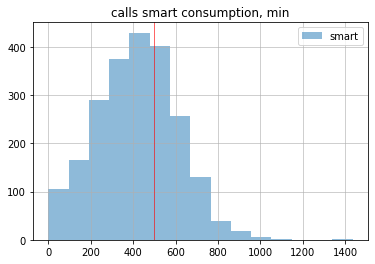

In [65]:
# гистограмма по тарифу смарт

pyplot.hist(smart['calls_duration'], alpha=0.5, label='smart',bins=15)

# лимит в 500 бесплатных минут
pyplot.axvline(500, color='r', linestyle='-',linewidth=0.6)

# легенда
pyplot.legend(loc='upper right')

# название
pyplot.title('calls smart consumption, min')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [66]:
# посчитаем дисперсию
# агрумент ddof=1, т.к. данные являются выборкой

# дисперсия по тарифу smart
x = smart['calls_duration'] # выборка
variance_estimate = np.var(x, ddof=1)
print(variance_estimate)

35844.1895513438


In [67]:
# тариф смарт, описание распределения

smart['calls_duration'].describe()

count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: calls_duration, dtype: float64

График напоминает нормальное распределение с выбросом в правой части, среднее значение составляет 419 минут, а стандартное отклонение 189 минут.<br> Медиана - 423 минуты.<br>Дисперсиия - 35844. Размах выборки - 1435. Межквартильный размах - 260. <br> Большинство значений расположены до бесплатного лимита в 500 минут.

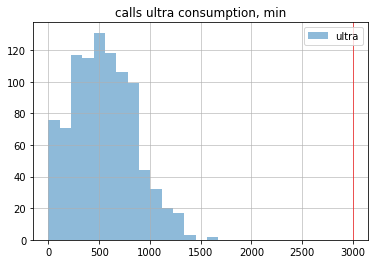

In [68]:
# гистограмма по тарифу ультра
pyplot.hist(ultra['calls_duration'], alpha=0.5, label='ultra',bins=15)

# лимит в 3000 бесплатных минут
pyplot.axvline(3000, color='r', linestyle='-',linewidth=0.6)

# легенда
pyplot.legend(loc='upper right')

# название
pyplot.title('calls ultra consumption, min')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [69]:
# дисперсия по тарифу ultra
y = ultra['calls_duration'] # выборка
variance_estimate = np.var(y, ddof=1)
print(variance_estimate) 

94203.41839614812


In [70]:
# тариф ультра, описание распределения
ultra['calls_duration'].describe()

count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: calls_duration, dtype: float64

График тарифа ультра более равномерно распределен, есть выбросы в правой части, среднее значение составляет 545 минут, а стандартное отклонение 306 минут. <br> Медиана - 528 минут.<br>Дисперсия - 94203 минут. Размах выборки - 1673 мин. Межквартильный размах - 446 мин. <br> Ни один пользователь не превысил бесплатный лимит по звонкам.

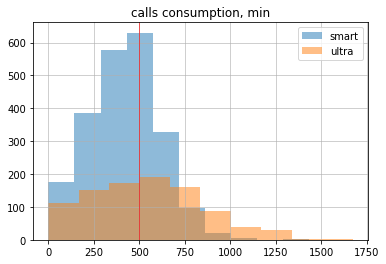

In [71]:
# выведем гистограммы для каждого из тарифов по потреблению телефонных звонков
pyplot.hist(smart['calls_duration'], alpha=0.5, label='smart',bins=10)
pyplot.hist(ultra['calls_duration'], alpha=0.5, label='ultra',bins=10)

# добавим линию лимита бесплатных телефонных звонков по тарифу smart
pyplot.axvline(500, color='r', linestyle='-',linewidth=0.6)

# добавим легенду
pyplot.legend(loc='upper right')

# добавим название
pyplot.title('calls consumption, min')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

График с потреблением звонков по двум тарифам и лимитом бесплатных звонков в 500 минут по тарифу smart.

<strong>Вывод:</strong><br>
Размер выборки тарифа smart в 2 раза выше, чем у тарифа ultra, тем не менее, среднее значение и медиана по тарифу ультра выше, чем по тарифу смарт. <br> Среднее значение по выборке для тарифа смарт составляет 83% от бесплатного лимита, в то время как по тарифу ультра среднее значение занимает всего 18% от бесплатного лимита. Т.е. можно сделать вывод, что пользователи тарифа ультра не ставят в приоритет большой лимит по звонкам при выборе тарифа, а пользователи smart активнее пользуются бесплатным лимитом.<br> Выборка по тарифу smart более скученная, стандартное отклонение и дисперсия сильно ниже, чем у тарифа ультра.

### Сообщения

Теперь рассмотрим потребление сообщений по обоим тарифам. Для этого построим гистограммы по каждому тарифу и опишем распределения.

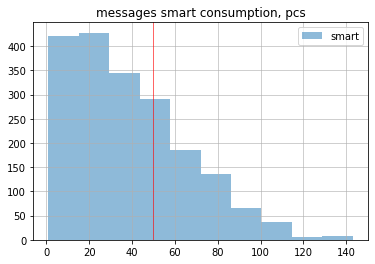

In [72]:
# гистограмма по тарифу смарт
pyplot.hist(smart['messages_count'], alpha=0.5, label='smart',bins=10)

# лимит бесплатного тарифа
pyplot.axvline(50, color='r', linestyle='-',linewidth=0.6)

# легенда
pyplot.legend(loc='upper right')

# название
pyplot.title('messages smart consumption, pcs')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [73]:
# посчитаем дисперсию
# агрумент ddof=1, т.к. данные являются выборкой

# дисперсия по тарифу smart
x = smart['messages_count'] # выборка
variance_estimate = np.var(x, ddof=1)
print(variance_estimate)

717.5942011753547


In [74]:
# тариф смарт, описание распределения

smart['messages_count'].describe()

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_count, dtype: float64

График стремится к распределнию Пуассона с затуханием в правой части.<br> Среднее значение - 38 сообщений.<br> Медиана - 34.<br> Стандарнтное отклонение - 26.7, дисперсия - 717. <br>Размах выборки - 142.<br> Основная часть пользователей находится до бесплатного лимита в 50 сообщений. Есть выбросы в правой части графика.

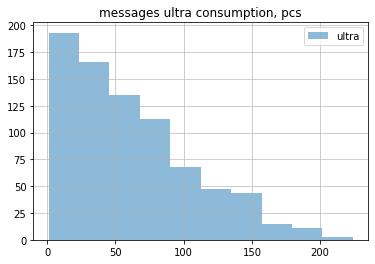

In [75]:
# гистограмма по тарифу ультра
pyplot.hist(ultra['messages_count'], alpha=0.5, label='ultra',bins=10)

# легенда
pyplot.legend(loc='upper right')

# название
pyplot.title('messages ultra consumption, pcs')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [76]:
# дисперсия по тарифу ultra
y = ultra['messages_count'] # выборка
variance_estimate = np.var(y, ddof=1)
print(variance_estimate)

2109.6591828651995


In [77]:
# тариф ультра, описание распределения
ultra['messages_count'].describe()

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_count, dtype: float64

График стремится к распределнию Пуассона с затуханием в правой части.<br> Среднее значение - 61 сообщение.<br> Медиана - 51.<br> Стандарнтное отклонение - 46, дисперсия - 2109. <br>Размах выборки - 223.<br> Все пользователи находятся до бесплатного порога в 1000 сообщений. 

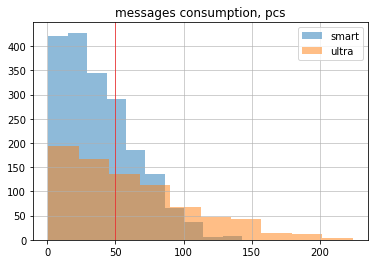

In [78]:
# выведем гистограммы для каждого из тарифов по потреблению телефонных звонков
pyplot.hist(smart['messages_count'], alpha=0.5, label='smart',bins=10)
pyplot.hist(ultra['messages_count'], alpha=0.5, label='ultra',bins=10)

# добавим линию лимита бесплатных телефонных звонков по тарифу smart
pyplot.axvline(50, color='r', linestyle='-', linewidth=0.6)

# добавим легенду
pyplot.legend(loc='upper right')

# добавим название
pyplot.title('messages consumption, pcs')

# cетка
pyplot.grid(visible=1, linewidth=0.6)

График с потреблением по двум тарифам и лимитом в 50 смс по тарифу smart.

Распределение по тарифу смарт более скученное, нежели по тарифу ультра (стандартное отклонение по тарифу ультра почти в 2 раза выше чем у тарифа смарт). Среднее значение по тарифу смарт составляет 76% от доступного бесплатного лимита, а по тарифу ультра - всего 6%.

<strong>Вывод:</strong><br>
Распределение по обоим тарифам стремится к распределению Пуассона с затуханием справа. Данные по тарифу смарт более скученные, хвост в правой части гистограммы короче. Пользователи тарифа смарт более активно пользуются возможностями бесплатного лимита.

### Интернет

Теперь рассмотрим распределения потребления по тарифам на интернет. Процедура аналогична предыдущим шагам.

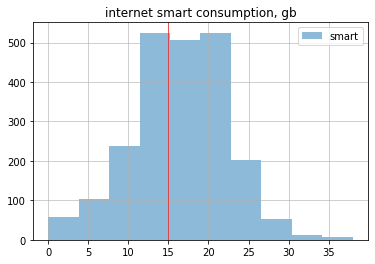

In [79]:
# гистограмма по тарифу смарт
pyplot.hist(smart['gb_used'], alpha=0.5, label='smart', bins=10)

# лимит бесплатного тарифа
pyplot.axvline(15, color='r', linestyle='-', linewidth=0.6)

# легенда
pyplot.legend(loc='upper right')

# название
pyplot.title('internet smart consumption, gb')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [80]:
# посчитаем дисперсию
# агрумент ddof=1, т.к. данные являются выборкой

# дисперсия по тарифу smart
x = smart['gb_used'] # выборка
variance_estimate = np.var(x, ddof=1)
print(variance_estimate)

32.92375582354312


In [81]:
# тариф смарт, описание распределения

smart['gb_used'].describe()

count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

График стремится к нормальному распределнию.<br> Среднее значение - 16 гб.<br> Медиана - 17.<br> Стандарнтное отклонение - 5.7, дисперсия - 33. <br>Размах выборки - 38.<br> Большая часть пользователей превышает по потреблению бесплатный лимит в 15 гб.

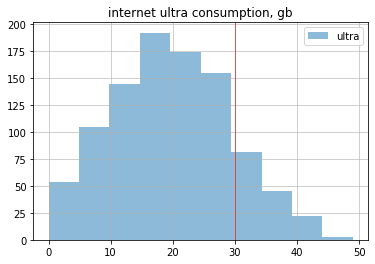

In [82]:
# гистограмма по тарифу ультра
pyplot.hist(ultra['gb_used'], alpha=0.5, label='ultra', bins=10)

# легенда
pyplot.legend(loc='upper right')

# лимит бесплатного тарифа ultra
pyplot.axvline(30, color='r', linestyle='-', linewidth=0.6)

# название
pyplot.title('internet ultra consumption, gb')

# сетка
pyplot.grid(visible=1, linewidth=0.6)

In [83]:
# дисперсия по тарифу ultra
y = ultra['gb_used'] # выборка
variance_estimate = np.var(y, ddof=1)
print(variance_estimate)

94.14673405991682


In [84]:
# тариф ультра, описание распределения

ultra['gb_used'].describe()

count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

График стремится к нормальному распределнию.<br> Среднее значение - 19.6 гб.<br> Медиана - 19.<br> Стандартное отклонение - 9.7, дисперсия - 94. <br>Размах выборки - 49.<br> Большая часть пользователей не превышает по потреблению бесплатный лимит в 30 гб.

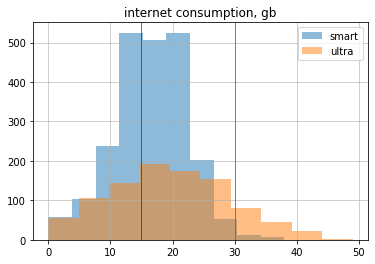

In [85]:
# выведем гистограммы для каждого из тарифов по потреблению телефонных звонков
pyplot.hist(smart['gb_used'], alpha=0.5, label='smart',bins=10)
pyplot.hist(ultra['gb_used'], alpha=0.5, label='ultra',bins=10)

# добавим линию лимита бесплатных телефонных звонков по тарифу smart
pyplot.axvline(30, color='r', linestyle='-',linewidth=0.6)
pyplot.axvline(15, color='b', linestyle='-',linewidth=0.6)

# добавим легенду
pyplot.legend(loc='upper right')

# добавим название
pyplot.title('internet consumption, gb')

# cетка
pyplot.grid(visible=1, linewidth=0.6)

График потребления трафика по обоим тарифам с указанием лимита бесплатных ГБ интернета.

Оба графика стремятся к нормальному распределению, однако данные по тарифу смарт более скученные, дисперсия и стандартное отклонение ниже, чем у тарифа ультра.

<strong>Вывод:</strong><br>
<br>Потребление по интернету и звонкам обоих тарифов стремится к нормальному распределению, потребление по сообщениям стремится к распределению Пуассона с затуханием справа. 

<br>Пользователи тарифа смарт практически полностью используют возможности бесплатных лимитов по всем типам связи, в то время как юзеры тарифа ультра по звонкам и смс используют лишь малую долю возможностей бесплатных лимитов.<br>

Самое большое среднее кол-во потребления по тарифу ультра обнаружено по потреблению интернета. Можно сделать вывод, что пользователи данного тарифа выбирают его за расширенный лимит по интернету, не обращая внимание на расширенные пакеты смс и звонков. Поэтому для компании имеется возможность сократить пакеты бесплатных смс и звонков для пользователей тарифа ультра без потери аудитории. Это позволит немного снизить стоимость данного тарифа и он станет более привлекательным для пользователей тарифа смарт.

## Проверка гипотез

На данном этапе нам нужно проверить две гипотезы:<br>
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;<br>
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.<br>

Пороговое значение alpha возьмем 0.05.

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза - средняя выручка от тарифа ультра равна средней выручке от тарифа смарт. <br>
Альтернативная - средняя выручка от тарифа ультра отличается от средней выручки от тарифа смарт

In [86]:
# дисперсия по выручке от тарифа ультра
x = ultra['income'] # совокупность
variance = np.var(x, ddof=1) # параметр ddof=1, т.к. датасет - выборка
print(variance) 

141516.7450786183


In [87]:
# дисперсия по выручке от тарифа смарт
x = smart['income'] # совокупность
variance = np.var(x, ddof=1) # параметр ddof=1, т.к. датасет - выборка
print(variance) 

669785.7080064242


Разница между дисперсиями велика, да и количество пользователей на разных тарифах разное, т.е. для проверки нулевой гипотезы указываем параметр "equal_var = False".

Применим метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам:

In [88]:
sample_1 = smart['income']
sample_2 = ultra['income']

alpha = .05 # критический уровень статистической значимости


results = st.ttest_ind(
    sample_1, 
    sample_2,
equal_var = False)

print('p-значение: ', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что выборка нерепрезентативна и связи между средними выручками по 2 тарифам нет. Нулевая гипотеза должна быть отвергнута. Таким образом, выбор тарифа влияет на размер выручки компании.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов<br>
Альтернативная гипотеза: средняя выручка пользователей из Москвы не равна средней выручке пользователей из регионов

In [89]:
# создадим 2 датафрейма для Москвы и остальных регионов
msk_income=df.query('city== "Москва"')
other_income=df.query('city!= "Москва"')

In [90]:
# дисперсия по выручке в Москве
x = msk_income['income'] # совокупность
variance = np.var(x, ddof=1) # параметр ddof=1, т.к. датасет - выборка
print(variance) 

565636.467011886


In [91]:
# дисперсия по средней выручке в других населенных пунктах
x = other_income['income'] # совокупность
variance = np.var(x, ddof=1) # параметр ddof=1, т.к. датасет - выборка
print(variance) 

654137.6285218114


Разница между дисперсиями велика, т.е. для проверки нулевой гипотезы указываем параметр "equal_var = False".

Снова применим метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам:

In [92]:
sample_1 = msk_income['income']
sample_2 = other_income['income']

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    sample_1, 
    sample_2,
equal_var = False)

print('p-значение: ', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


<strong>Вывод:</strong><br>
Результаты теста показывают, что нулевая гипотеза о том, что средняя выручка по пользователям в Москве равна средней выручке по пользователям из регионов не отвергнута. Следовательно, выручка компании не зависит от населенного пункта, в котором зарегистрирован клиент.

## Общий вывод

В данном исследовании мы провели большую работу по анализу выборки потребления услуг пользователей тарифов Ультра и Смарт. <br>

1. С помощью нескольких источников мы сформировали единую сводную таблицу
2. Выполнили предобработку данных
3. Выяснили, сколько денег получает компания с каждого пользователя в зависимости от его потребления и выбранного тарифа.
4. Проанализировали распределения каждого типа связи, нашли среднее.
5. Проверили 2 гипотезы, связанные с выбором тарифа и выручкой компании, а также влияет ли выбор региона на объем прибыли компании.<br>

В результате проведенного исследования можно сделать вывод, что для компании тариф "ультра" является более выгодным: это показала и первая отвергнутая гипотеза о равенстве тарифов по выручке, и тот факт, что пользователи данного тарифа сравнительно мало используют бесплатные лимиты. Однако, количество пользователей у тарифа смарт выше. Влияние региона на выручку компании не выявлено, возможно, в регионах пользователи предпочитают меньший ежемесячный тариф, но готовы переплатить за выход из бесплатного лимита, в то время как в Москве клиенты готовы платить за тариф больше, но быть уверенными, что доступных лимитов хватит на месяц.